# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.


## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/)). Para la entrega 2 hay nuevas dependencias, por lo que es importante correr la siguiente celda.

In [90]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
import re
import os

from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')  # Necesario para tokenizar
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')   # Para sinónimos y definiciones
nltk.download('averaged_perceptron_tagger_eng')  # Para etiquetas gramaticales

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lulag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lulag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lulag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lulag\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\lulag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Lectura de Datos

In [92]:
# DataFrame con todos los discursos:
pd.set_option('display.max_rows', None)
df_speeches = pd.read_csv('C:/Users/lulag/introCD/data/us_2020_election_speeches.csv')
df_speeches

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\r\nHow great is it to be...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\r\nHello, Michigan. Hi, how...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\r\nThank you. What a ...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\r\nHey, and wel...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\r\nIt’s nothing but ...,"Oct 15, 2020",NBC,Town Hall
5,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...",Donald Trump: (01:25)\r\nThank you very much. ...,"Oct 15, 2020","Greenville, North Carolina",Campaign Speech
6,Mike Pence,Mike Pence Campaign Speech Miami Transcript Oc...,"Pedro Fuentes Cid: (01:08)\r\nYeah, my name is...","Oct 15, 2020","Miami, Florida",Campaign Speech
7,Donald Trump,"Donald Trump Rally Des Moines, Iowa Transcript...",President Donald J. Trump: (14:59)\r\nThank yo...,"Oct 14, 2020","Des Moines, Iowa",Campaign Speech
8,Mike Pence,"Mike Pence Campaign Speech Grand Rapids, Michi...","Mike Pence: (02:27)\r\nWell hello, Michigan. T...","Oct 14, 2020","Grand Rapids, Michigan",Campaign Speech
9,Joe Biden,"Joe Biden Mobilization Campaign Event Miramar,...","Speaker 1: (01:06)\r\nPlease welcome, Damian F...","Oct 13, 2020","Miramar, Florida",Campaign Speech


In [93]:
# Separación de speakers múltiples
df_speeches['speaker'] = df_speeches['speaker'].str.split(',')
df_speeches = df_speeches.explode('speaker')
df_speeches['speaker'] = df_speeches['speaker'].str.strip()

In [94]:
# Selección de los 3 candidatos con más discursos
presidents = ["Joe Biden", "Donald Trump", "Mike Pence"]

# df_speeches_top_3 = ...
def presencia(df, column, names):
    return df[column].astype(str).apply(lambda x: 1 if any(name in x for name in names) else 0)
boolean = presencia(df_speeches, 'speaker', presidents)    
df_speeches_top_3 = df_speeches[boolean == 1]
# Eliminación de Donald Trump Jr. (hijo)
df_speeches_top_3 = df_speeches_top_3.drop(136)

# Reseteo del índice
df_speeches_top_3.reset_index(drop=True, inplace=True)
df_speeches_top_3

,speaker,title,text,date,location,type
0,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\r\nHello, Michigan. Hi, how...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
1,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\r\nThank you. What a ...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
2,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\r\nHey, and wel...","Oct 15, 2020",ABC,Town Hall
3,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\r\nIt’s nothing but ...,"Oct 15, 2020",NBC,Town Hall
4,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...",Donald Trump: (01:25)\r\nThank you very much. ...,"Oct 15, 2020","Greenville, North Carolina",Campaign Speech
5,Mike Pence,Mike Pence Campaign Speech Miami Transcript Oc...,"Pedro Fuentes Cid: (01:08)\r\nYeah, my name is...","Oct 15, 2020","Miami, Florida",Campaign Speech
6,Donald Trump,"Donald Trump Rally Des Moines, Iowa Transcript...",President Donald J. Trump: (14:59)\r\nThank yo...,"Oct 14, 2020","Des Moines, Iowa",Campaign Speech
7,Mike Pence,"Mike Pence Campaign Speech Grand Rapids, Michi...","Mike Pence: (02:27)\r\nWell hello, Michigan. T...","Oct 14, 2020","Grand Rapids, Michigan",Campaign Speech
8,Joe Biden,"Joe Biden Mobilization Campaign Event Miramar,...","Speaker 1: (01:06)\r\nPlease welcome, Damian F...","Oct 13, 2020","Miramar, Florida",Campaign Speech
9,Donald Trump,"Donald Trump Rally Johnstown, PA Transcript Oc...","President Trump: (01:02)\r\nHello, Johnstown. ...","Oct 13, 2020","Johnstown, Pennsylvania",Campaign Speech


## Limpieza de Textos

In [95]:
# 1 - Función clean_text() de la entrega anterior

def clean_text(df, column_name):
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    # Convertir todo a minúsculas
    result = result.str.lower()
    # Completar signos de puntuación faltantes
    for punc in ["\n", "[", "]", ",", ":", ".", ";", "!", "”", "“", "-", "/", "(", ")", "?","…","’","‘"]:
        result = result.str.replace(punc, " ")
    return result

# Creación de una nueva columna CleanText a partir de text
df_speeches_top_3["CleanText"] = clean_text(df_speeches_top_3,'text')
# df_speeches_top_3["CleanText"]

In [96]:
# 2 - Eliminación de stopwords

# Lista de stopwords
stop_words = set(stopwords.words('english'))
# print(stop_words)

# Función para eliminar stopwords de un texto
def remove_stopwords(text):
    tokens = word_tokenize(text)  # Divide el texto en palabras
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(remove_stopwords)
# df_speeches_top_3["CleanText"]

In [97]:
# 3 - Separación de contracciones y escritura de forma completa

# La lista de stopwords que se eliminaron en la celda anterior incluye varias contracciones.
# En este paso se expande la contracciones que puedan no haber sido consideradas por la lista de stopwords de nltk.
contraction_list = {
    "let's": "let us",
    "what's": "what is",
    "it's": "it is",
    "you'll": "you will",
    "i'll": "i will",
    "i'm": "i am",
    "he'll": "he will",
    "she'll": "she will",
    "they'll": "they will",
    "we'll": "we will",
    "can't": "cannot",
    "won't": "will not",
    "doesn't": "does not",
    "don't": "do not",
    "isn't": "is not",
    "aren't": "are not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "i've": "i have",
    "you've": "you have",
    "you're": "you are",
    "we've": "we have",
    "we're": "we are",
    "they're": "they are",
    "they've": "they have",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "here's": "here is",
    "wasn't": "was not",
    "weren't": "were not",
    "didn't": "did not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "it'd": "it would",
    "who's": "who is",
    "who've": "who have",
    "who'd": "who would",
    "how's": "how is",
    "when's": "when is",
    "why's": "why is",
    "ain't": "is not",
}
# Sustitución del apóstrofe gráfico
df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(lambda x: x.replace("’", "'") if isinstance(x, str) else x)
def expand_contractions(text, contractions=contraction_list):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in contractions.keys()) + r')\b')
    return pattern.sub(lambda x: contractions[x.group()], text)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(expand_contractions)

In [98]:
# 4 - Eliminación de números

def remove_numbers(text):
    # Elimina números, 
    # incluyendo sufijos como: 'th', 'st', 'nd', 'rd', 's'.
    return re.sub(r'\b\d+(?:\.\d+)?(?:st|nd|rd|th|s|k|ks|census)?\b', '', text)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(remove_numbers)

In [99]:
# 5 - Lematización

# Inicialización del lematizador
lemmatizer = WordNetLemmatizer()

# Función para mapear etiquetas POS de nltk a las que requiere WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default

# Función de lematización
def lemmatize_text(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(lemmatize_text)
# df_speeches_top_3["CleanText"]

## Parte 1: Dataset y representación numérica de texto

In [100]:
# 1: Separar del 30% del conjunto para test. Al 70 % restante para entrenamiento se lo llama "dev" (desarrollo).

# Definición de variables
X = df_speeches_top_3["CleanText"]      # Características: transcripciones de discursos (columna 'CleanText' del DataFrame)
y = df_speeches_top_3["speaker"]        # Etiqueta: presidente que pronunció el discurso (columna 'speaker' del DataFrame)

# División estratificada
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y,
    test_size = 0.3,            # 30% se separa para test
    stratify = y,               # Respeta las proporciones entre candidatos
    random_state = 17           # Para reproducibilidad
)

print(f"Tamaños de los conjuntos: \nEntrenamiento:{X_dev.shape} Testeo:{X_test.shape}")

Tamaños de los conjuntos: 
Entrenamiento:(108,) Testeo:(47,)


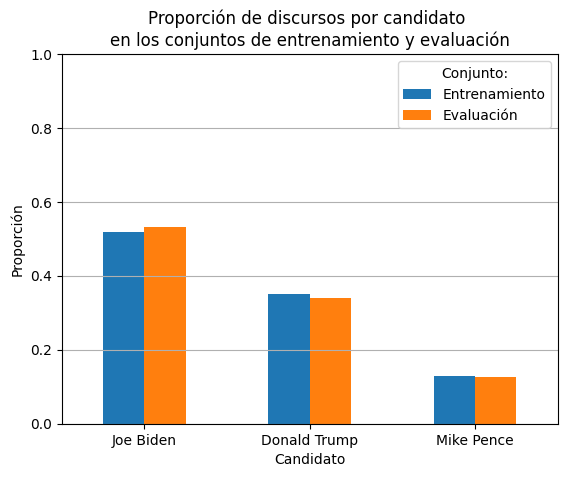

In [101]:
# 2: Visualización de la proporción de cada candidato por conjunto

# Creación de un DataFrame con las proporciones
train_dist = y_dev.value_counts(normalize=True).rename("Entrenamiento")
test_dist = y_test.value_counts(normalize=True).rename("Evaluación")
balance_df = pd.concat([train_dist, test_dist], axis=1)

# Gráfico de barras
balance_df.plot(kind='bar')
plt.title("Proporción de discursos por candidato \nen los conjuntos de entrenamiento y evaluación")
plt.xlabel("Candidato")
plt.ylabel("Proporción")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Conjunto:')
plt.show()

In [102]:
# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.

# Creación del vectorizador
vectorizer = CountVectorizer()

# Entrenamiento y transformación de los textos
X_dev_bow = vectorizer.fit_transform(X_dev)

# Mostrar la forma de la matriz
print("Dimensiones de la matriz BoW:", X_dev_bow.shape)
# Ejemplo: primeras 5 palabras del vocabulario
print("Primeras palabras del vocabulario:", vectorizer.get_feature_names_out()[10:20])

Dimensiones de la matriz BoW: (108, 10877)
Primeras palabras del vocabulario: ['abdelaziz' 'abdicate' 'abdul' 'abe' 'aberration' 'abet' 'abhorrent'
 'abide' 'abiding' 'ability']


In [103]:
# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.

# Inicialización del transformador
tfidf_transformer = TfidfTransformer()
# Ajuste y transformación de la matriz de conteo
X_dev_tfidf = tfidf_transformer.fit_transform(X_dev_bow)

# Mostrar la forma de la matriz
print("Dimensiones de la matriz TfIdf:", X_dev_tfidf.shape)

Dimensiones de la matriz TfIdf: (108, 10877)


In [104]:
# Visualización de TF-IDF > 0 para un discurso de ejemplo

# Para el primer speech: Joe Biden
text_index = 0

# Vector TF-IDF en formato denso
text_vector = X_dev_tfidf[text_index].toarray()[0]

# Nombres de las palabras
feature_names = vectorizer.get_feature_names_out()

# Filtro de términos con TF-IDF > 0
non_zero_terms = [(feature_names[i], text_vector[i]) 
                  for i in range(len(text_vector)) if text_vector[i] > 0]

# Visualización de términos con su peso (ordenados por importancia)
non_zero_terms_sorted = sorted(non_zero_terms, key=lambda x: x[1], reverse=True)
# Primeros 10
print(non_zero_terms_sorted[:10])

[('job', np.float64(0.22536977110122877)), ('make', np.float64(0.21525578695745962)), ('ufcw', np.float64(0.1819676687660987)), ('go', np.float64(0.1761182796313726)), ('biden', np.float64(0.1448268219049189)), ('matt', np.float64(0.14323753740453532)), ('hoffman', np.float64(0.14084392141284777)), ('pay', np.float64(0.14029474557067156)), ('joe', np.float64(0.13758548080967298)), ('get', np.float64(0.13384989251984317))]


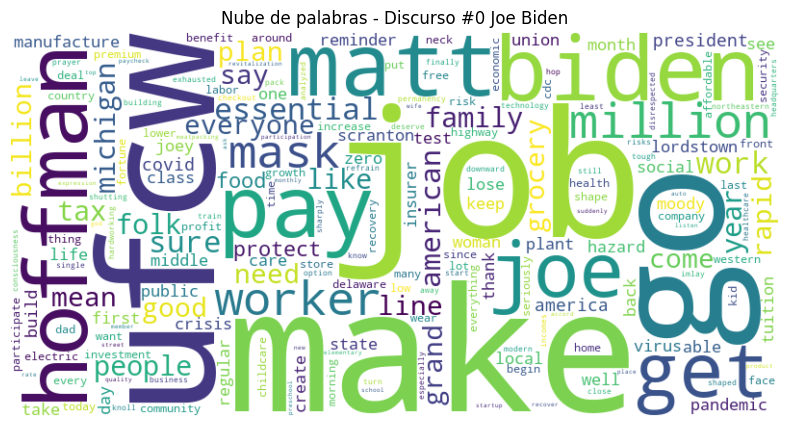

In [105]:
# Visualización de lo anterior como Wordmap

# Creación del diccionario: {palabra: peso TF-IDF}
word_weights = {
    feature_names[i]: text_vector[i]
    for i in range(len(text_vector)) if text_vector[i] > 0
}

# Generación de la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_weights)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Nube de palabras - Discurso #{text_index} {df_speeches_top_3.iloc[text_index]["speaker"]}')
plt.show()

## Parte 2: Entrenamiento y Evaluación de Modelos


In [106]:
# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. Reporte el valor de precision y recall para cada candidato. 
# Calcular matriz de confusión. Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.

# Transformación de textos de test al espacio de BoW usando el vectorizer entrenado
X_test_bow = vectorizer.transform(X_test)

# Transformación de matriz BoW al espacio TF-IDF usando el transformer entrenado
X_test_tfidf = tfidf_transformer.transform(X_test_bow) 

# Mostrar la forma de la matriz
print("Dimensiones de la matriz TfIdf:", X_test_tfidf.shape)

Dimensiones de la matriz TfIdf: (47, 10877)


In [107]:
# Entrenamiento del modelo con el conjunto de desarrollo
nb_model = LogisticRegression(solver='liblinear', max_iter=1000, C=1)
nb_model.fit(X_dev_tfidf, y_dev)  # y_dev vector con las etiquetas (candidatos)

# Predicción de las etiquetas del conjunto de test
y_pred = nb_model.predict(X_test_tfidf)

# Cálculo de accuracy (porcentaje de aciertos)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9574


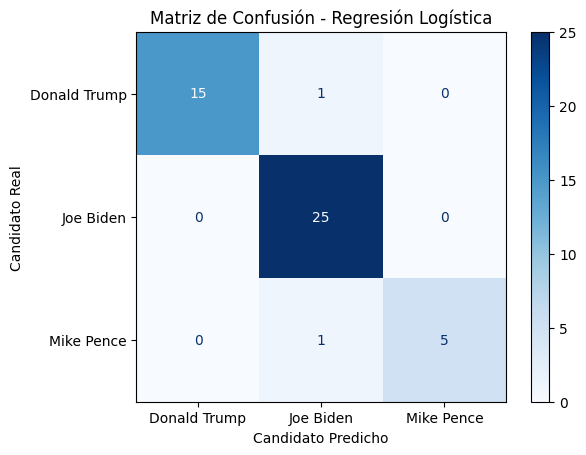

In [108]:
# Matriz de Confusión 

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Candidato Predicho")
plt.ylabel("Candidato Real")
plt.show()

In [109]:
# Revisión de las clases reales y predichas
print("Clases verdaderas en test:", np.unique(y_test))
print("Clases predichas por el modelo:", np.unique(y_pred))

# Para ver la frecuencia de cada clase
print("\nFrecuencia de clases verdaderas:")
print(pd.Series(y_test).value_counts())

print("\nFrecuencia de clases predichas:")
print(pd.Series(y_pred).value_counts())

Clases verdaderas en test: ['Donald Trump' 'Joe Biden' 'Mike Pence']
Clases predichas por el modelo: ['Donald Trump' 'Joe Biden' 'Mike Pence']

Frecuencia de clases verdaderas:
speaker
Joe Biden       25
Donald Trump    16
Mike Pence       6
Name: count, dtype: int64

Frecuencia de clases predichas:
Joe Biden       27
Donald Trump    15
Mike Pence       5
Name: count, dtype: int64


In [110]:
# Precisión y Recall para cada Candidato

print("Reporte de métricas por candidato:")
print(classification_report(y_test, y_pred, zero_division=0))

Reporte de métricas por candidato:
              precision    recall  f1-score   support

Donald Trump       1.00      0.94      0.97        16
   Joe Biden       0.93      1.00      0.96        25
  Mike Pence       1.00      0.83      0.91         6

    accuracy                           0.96        47
   macro avg       0.98      0.92      0.95        47
weighted avg       0.96      0.96      0.96        47



In [111]:
# Hiperparámetros por defecto del modelo

# Diccionario con todos los parámetros posibles
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
params = pipeline.get_params()

# Visualización como tabla
params_df = pd.DataFrame(params.items(), columns=["Hiperparámetro", "Valor por defecto"])
params_df

,Hiperparámetro,Valor por defecto
0,memory,None
1,steps,"[(tfidf, TfidfVectorizer()), (clf, LogisticReg..."
2,transform_input,None
3,verbose,False
4,tfidf,TfidfVectorizer()
5,clf,LogisticRegression()
6,tfidf__analyzer,word
7,tfidf__binary,False
8,tfidf__decode_error,strict
9,tfidf__dtype,<class 'numpy.float64'>


In [112]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),        # Paso 1: convierte el texto en vectores TF-IDF.
    ('clf', LogisticRegression())        # Paso 2: entrena un clasificador Naive Bayes con esos vectores.
])

# Definición de hiperparámetros a explorar
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],   # Define si se usan solo unigramas o también bigramas.
    'tfidf__min_df': [1, 3],                  # Ignora palabras que aparecen en menos de n documentos.
    'tfidf__max_df': [0.9, 1.0],              # Ignora palabras que aparecen en más de n documentos.
    'clf__C': [0.1, 1, 10],                   # C = regularización inversa (c pequeño = menor riesgo de overfitting).
    'clf__penalty': ['l1', 'l2'],             # l1 penaliza el valor absoluto del error y l2 el ECM. 
    'clf__solver': ['liblinear']              # liblinear es compatible con l1 y l2
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                        # Validación cruzada con 5 particiones.
    scoring='accuracy',          # Métrica para comparar modelos: accuracy.
    return_train_score=True,
    n_jobs=-1
)

grid.fit(X_dev, y_dev)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10], 'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear'],
                         'tfidf__max_df': [0.9, 1.0], 'tfidf__min_df': [1, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='accuracy')

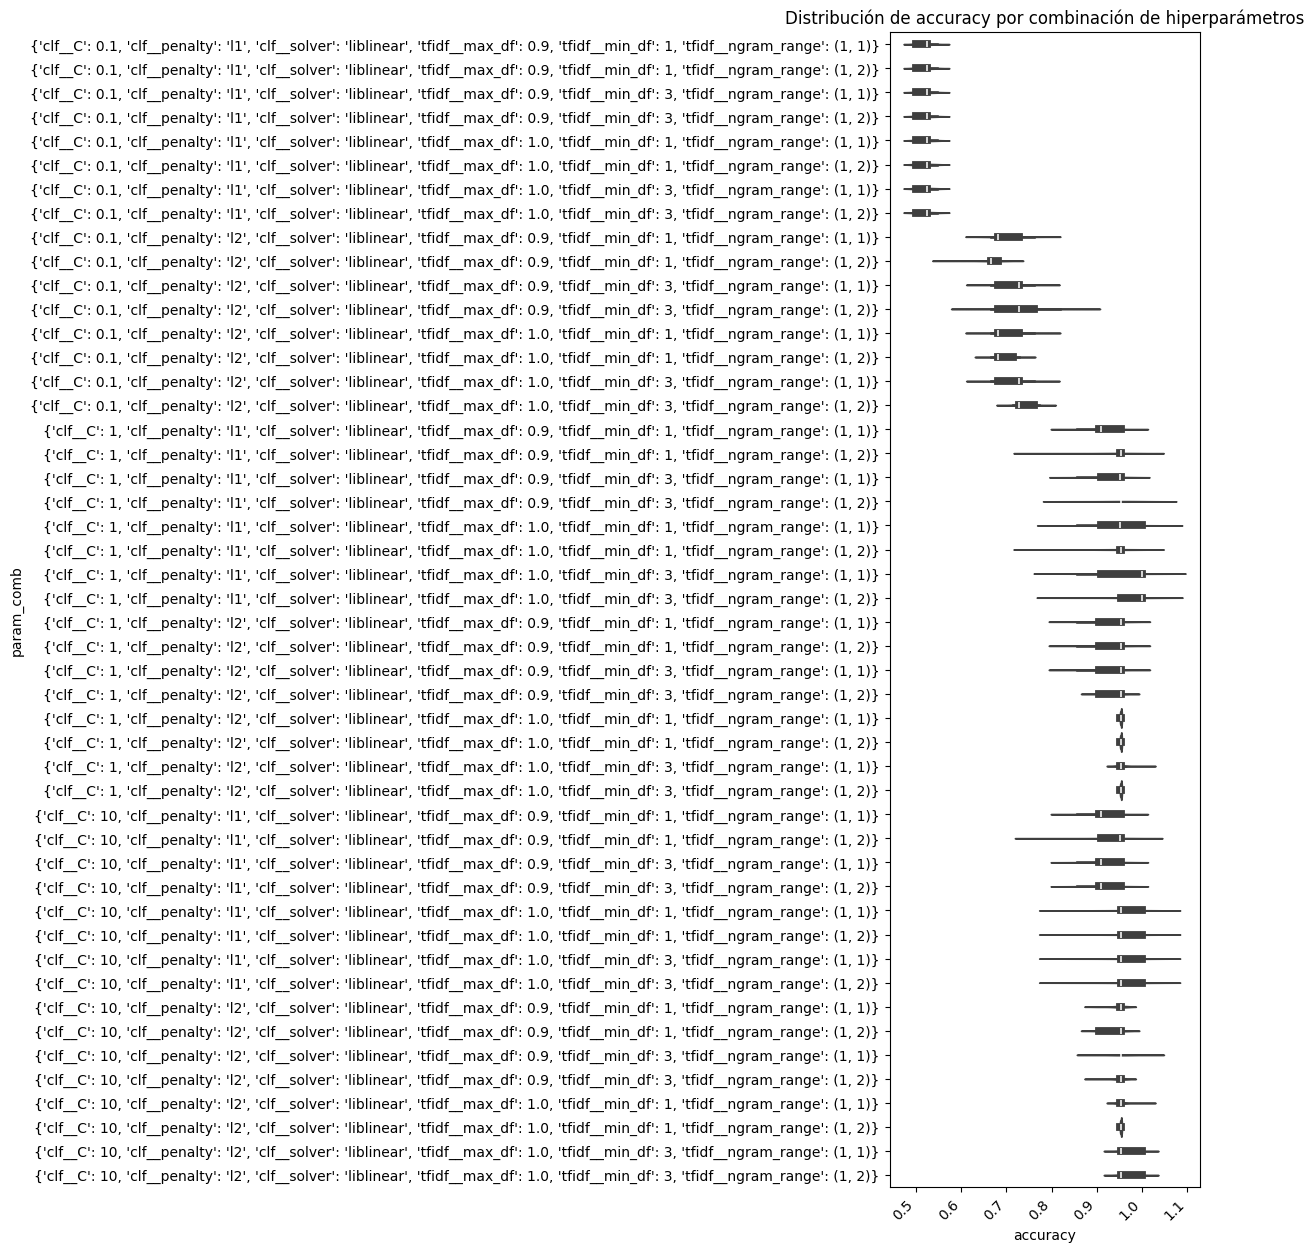

In [113]:
# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

# Conversión de los resultados en un DataFrame
results = pd.DataFrame(grid.cv_results_)

# Creación de una columna identificadora de cada combinación de hiperparámetros
results['param_comb'] = results['params'].apply(lambda d: str(d))

# Creación de un DataFrame "long" para seaborn
split_scores = []

for i in range(grid.cv):
    split_scores.extend([
        {
            'param_comb': results.loc[j, 'param_comb'],
            'split': i,
            'accuracy': results.loc[j, f'split{i}_test_score']
        }
        for j in range(len(results))
    ])

split_scores_df = pd.DataFrame(split_scores)

# Gráfico de violín
plt.figure(figsize=(4, 15))
sns.violinplot(
    data=split_scores_df,
    y='param_comb',
    x='accuracy'
)
plt.xticks(rotation=45, ha='right')
plt.title("Distribución de accuracy por combinación de hiperparámetros")
plt.show()

In [114]:
# 3: Elija el mejor modelo (mejores parámetros) y vuelva a entrenar sobre todo el conjunto de entrenamiento disponible (sin quitar datos para validación). Reporte el valor final de las métricas y la matriz de confusión.

# Mejores hiperparámetros encontrados 
print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)
print("Accuracy Promedio:")
print(grid.best_score_)

# Mejor modelo entrenado
best_model = grid.best_estimator_

Mejores hiperparámetros encontrados:
{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_df': 1.0, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Accuracy Promedio:
0.9722943722943723


Reporte de clasificación:

              precision    recall  f1-score   support

Donald Trump       1.00      1.00      1.00        16
   Joe Biden       0.96      1.00      0.98        25
  Mike Pence       1.00      0.83      0.91         6

    accuracy                           0.98        47
   macro avg       0.99      0.94      0.96        47
weighted avg       0.98      0.98      0.98        47



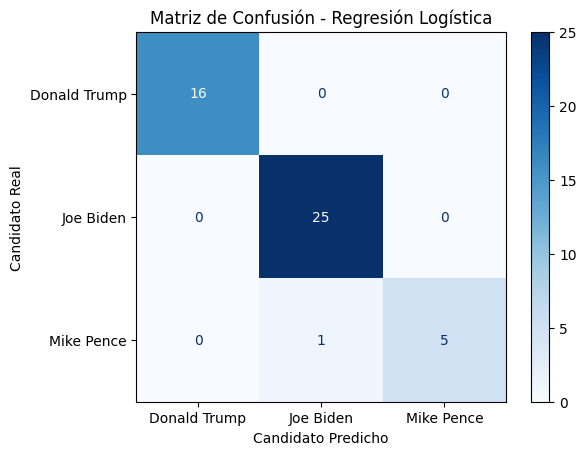

In [115]:
# Reentrenamiento del modelo sobre todo el conjunto de desarrollo
best_model.fit(X_dev, y_dev)

# Predicción de etiquetas para el conjunto de testeo
y_test_pred = best_model.predict(X_test)

# Reporte de métricas finales
print("Reporte de clasificación:\n")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Candidato Predicho")
plt.ylabel("Candidato Real")
plt.show()